# Playing Fitbit: Predicting subject activity in the MHealth dataset

The [MHealth dataset](http://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset) from UC Irvine includes data from sensors on different parts of the subject's body while performing 12 different exercises:

1. Standing still (1 min)
2. Sitting and relaxing (1 min)
3. Lying down (1 min)
4. Walking (1 min)
5. Climbing stairs (1 min)
6. Waist bends forward (20x)
7. Frontal elevation of arms (20x)
8. Knees bending (crouching) (20x)
9. Cycling (1 min)
10. Jogging (1 min)
11. Running (1 min)
12. Jump front & back (20x)

The dataset includes 1,215,745 samples, 343,195 labeled with a known activity.

It is based on 4 sensors placed on the body:

- 2-lead ECG
- 3 monitors placed around body
    - Locations
        - Chest
        - Left ankle
        - Right lower-arm
    - Sensors
        - Accelerometer (X, Y, Z)
        - Gyroscope (X, Y, Z) - *not on chest*
        - Magnetometer (X, Y, Z)

Data based on 23 different sensor inputs:

1. acceleration from the chest sensor (X axis)
2. acceleration from the chest sensor (Y axis)
3. acceleration from the chest sensor (Z axis)
4. electrocardiogram signal (lead 1)
5. electrocardiogram signal (lead 2)
6. acceleration from the left-ankle sensor (X axis)
7. acceleration from the left-ankle sensor (Y axis)
8. acceleration from the left-ankle sensor (Z axis)
9. gyro from the left-ankle sensor (X axis)
10. gyro from the left-ankle sensor (Y axis)
11. gyro from the left-ankle sensor (Z axis)
13. magnetometer from the left-ankle sensor (X axis)
13. magnetometer from the left-ankle sensor (Y axis)
14. magnetometer from the left-ankle sensor (Z axis)
15. acceleration from the right-lower-arm sensor (X axis)
16. acceleration from the right-lower-arm sensor (Y axis)
17. acceleration from the right-lower-arm sensor (Z axis)
18. gyro from the right-lower-arm sensor (X axis)
19. gyro from the right-lower-arm sensor (Y axis)
20. gyro from the right-lower-arm sensor (Z axis)
21. magnetometer from the right-lower-arm sensor (X axis)
22. magnetometer from the right-lower-arm sensor (Y axis)
23. magnetometer from the right-lower-arm sensor (Z axis)


## Part 1: Data Review and Initialization

### Initial Setup and Data Loading

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.tools.merge import concat
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import neighbors
from collections import Counter
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import train_test_split

%matplotlib inline

cols = ["ChestX","ChestY","ChestZ","ECGl1","ECGl2","AnkleAccX","AnkleAccY","AnkleAccZ","AnkleGyroX","AnkleGyroY","AnkleGyroZ","AnkleMagX","AnkleMagY","AnkleMagZ","ArmAccX","ArmAccY","ArmAccZ","ArmGyroX","ArmGyroY","ArmGyroZ","ArmMagX","ArmMagY","ArmMagZ","Label"]
labelMap = {
        1: "Standing still (1 min)",
        2: "Sitting and relaxing (1 min)",
        3: "Lying down (1 min)",
        4: "Walking (1 min)",
        5: "Climbing stairs (1 min)",
        6: "Waist bends forward (20x)",
        7: "Frontal elevation of arms (20x)",
        8: "Knees bending (crouching) (20x)",
        9: "Cycling (1 min)",
        10: "Jogging (1 min)",
        11: "Running (1 min)",
        12: "Jump front & back (20x)"
    }

# Main dataframe
data = pd.DataFrame()

# Loop through 10 data files and load into data
list_ = []
for i in range(1,11):
    df = pd.read_csv("data/mHealth_subject"+str(i)+".log",index_col=None, names=cols, delimiter="\t")
    list_.append(df)
data = pd.concat(list_)
print "Raw data shape: "+str(data.shape)

# Delete rows with no activity label
data = data[data.Label != 0]
print "Labeled data shape: "+str(data.shape)

# Create subset of data to reduce complexity
data = data.loc[np.random.choice(data.index, 4000, replace=False)]
print "Reduced data shape: "+str(data.shape)

Raw data shape: (1215745, 24)
Labeled data shape: (343195, 24)
Reduced data shape: (14652, 24)


### Base data exploration

#### Understanding the values

A simple description is helpful to understanding the types of values we are looking at, across the different types of sensors.

In [2]:
data.describe()

,ChestX,ChestY,ChestZ,ECGl1,ECGl2,AnkleAccX,AnkleAccY,AnkleAccZ,AnkleGyroX,AnkleGyroY,...,ArmAccX,ArmAccY,ArmAccZ,ArmGyroX,ArmGyroY,ArmGyroZ,ArmMagX,ArmMagY,ArmMagZ,Label
count,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,...,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000
mean,-7.392275,-0.221274,-0.801785,0.011842,0.001683,1.834023,-8.875922,-0.434469,0.105582,-0.540891,...,-3.281198,-6.002792,2.465604,-0.184686,-0.421730,0.375654,-0.252102,1.738737,-1.432881,5.834364
std,5.506322,2.776695,4.703184,0.820059,0.805860,4.033113,5.140648,6.328172,0.451174,0.444435,...,5.509091,6.275889,4.058950,0.543758,0.556169,0.505812,31.833716,28.333848,76.496878,3.225619
min,-22.263000,-19.968000,-18.392000,-8.619600,-8.619600,-22.135000,-19.570000,-19.363000,-1.740300,-2.309600,...,-22.168000,-18.942000,-18.228000,-1.170600,-2.234100,-0.991380,-260.280000,-291.550000,-570.430000,1.000000
25%,-9.692850,-1.395500,-3.619075,-0.205130,-0.166405,0.218033,-9.962900,-3.081700,-0.337660,-0.810510,...,-4.926225,-9.610375,0.235322,-0.668630,-0.852160,-0.036638,-4.816525,-5.938350,-10.356000,3.000000
50%,-8.793400,-0.407210,-0.759570,-0.075353,-0.050235,1.381800,-9.591100,0.498505,0.196660,-0.682930,...,-2.413400,-7.866550,1.879550,-0.258820,-0.626280,0.441810,0.360770,0.353930,-0.711080,6.000000
75%,-4.995675,0.916040,1.205725,0.154890,0.129770,2.905275,-7.462000,1.942575,0.483765,-0.489680,...,-0.569070,-2.393100,5.393325,0.300000,-0.024641,0.825430,4.395500,7.325425,7.719850,9.000000
max,18.958000,20.218000,12.838000,8.506500,8.502400,20.013000,20.959000,24.828000,1.599300,1.515900,...,19.801000,21.844000,24.136000,1.321600,1.106800,1.519400,217.750000,291.670000,551.000000,12.000000


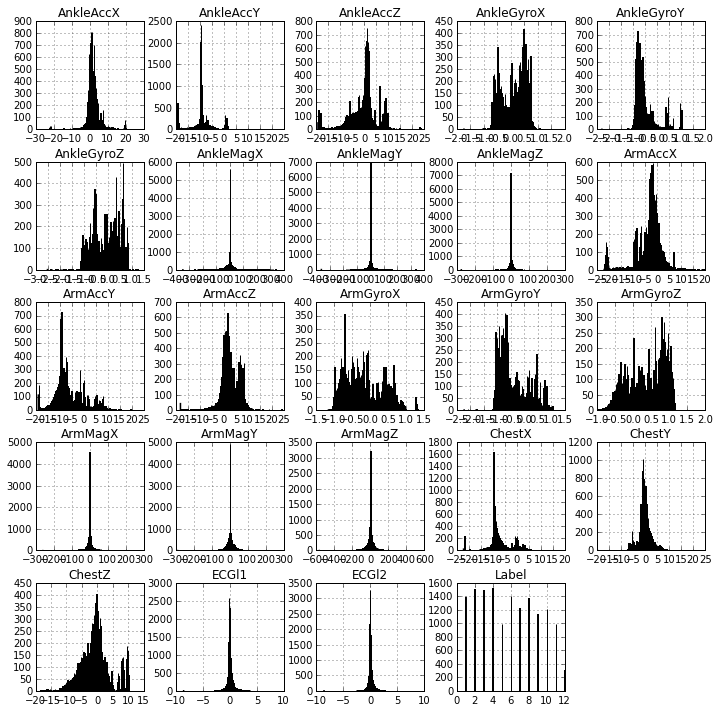

In [3]:
# Attribute histograms
data.hist(figsize=(12, 12), bins=185);

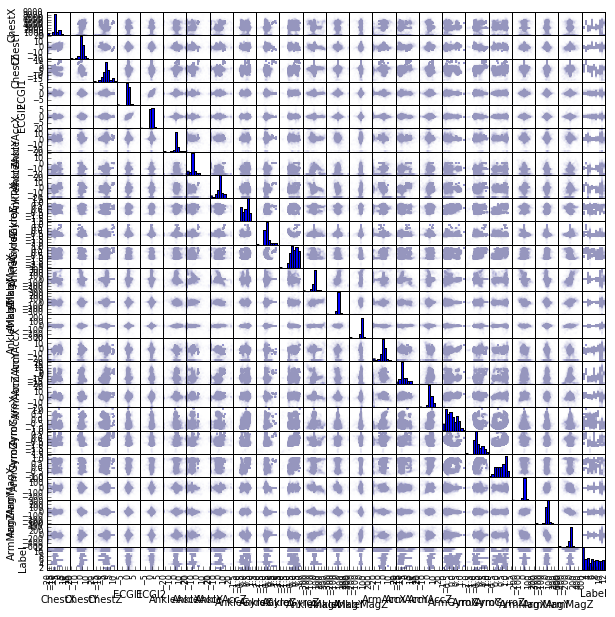

In [4]:
pd.scatter_matrix(data, figsize=(10, 10), s=20, alpha=0.01, cmap='brg', edgecolors='gray');

#### Activity instances

A quick value_counts on *Label* demonstrates relative uniformity across instances, except jumping.

In [5]:
def actName(num):
    return labelMap[num]

vc = pd.DataFrame(data["Label"].value_counts())
vc.index.name = "Action"
vc.rename(columns={0:"Instances"}, inplace=True)
vc.index = vc.index.map(actName)
vc

,Instances
Walking (1 min),1519
Sitting and relaxing (1 min),1515
Lying down (1 min),1488
Waist bends forward (20x),1406
Standing still (1 min),1387
Knees bending (crouching) (20x),1374
Frontal elevation of arms (20x),1220
Jogging (1 min),1215
Cycling (1 min),1140
Running (1 min),989


### Data manipulation

In [6]:
activityFeatures = ["is_standing","is_sitting","is_lying","is_walking","is_climbing","is_bending","is_lifting_arms","is_bending_knees","is_cycling","is_jogging","is_running","is_jumping"]

actY = pd.DataFrame()

# Create activity-specific binary features
actY["is_standing"] = (data.Label == 1).astype(int)
actY["is_sitting"] = (data.Label == 2).astype(int)
actY["is_lying"] = (data.Label == 3).astype(int)
actY["is_walking"] = (data.Label == 4).astype(int)
actY["is_climbing"] = (data.Label == 5).astype(int)
actY["is_bending"] = (data.Label == 6).astype(int)
actY["is_lifting_arms"] = (data.Label == 7).astype(int)
actY["is_bending_knees"] = (data.Label == 8).astype(int)
actY["is_cycling"] = (data.Label == 9).astype(int)
actY["is_jogging"] = (data.Label == 10).astype(int)
actY["is_running"] = (data.Label == 11).astype(int)
actY["is_jumping"] = (data.Label == 12).astype(int)

# Filter to columns with arm data
X_arm = data[["ArmAccX","ArmAccY","ArmAccZ","ArmGyroX","ArmGyroY","ArmGyroZ","ArmMagX","ArmMagY","ArmMagZ","Label"]]
X_ankle = data[["AnkleAccX","AnkleAccY","AnkleAccZ","AnkleGyroX","AnkleGyroY","AnkleGyroZ","AnkleMagX","AnkleMagY","AnkleMagZ"]]
X_chest = data[["ChestX","ChestY","ChestZ"]]
X_ecg = data[["ECGl1","ECGl2"]]

sensorGroup = ["arm","ankle","chest","ecg"]

print "Arm data shape: "+str(X_arm.shape)
print "Ankle data shape: "+str(X_ankle.shape)
print "Chest data shape: "+str(X_chest.shape)
print "ECG data shape: "+str(X_ecg.shape)

Arm data shape: (14550, 10)
Ankle data shape: (14550, 9)
Chest data shape: (14550, 3)
ECG data shape: (14550, 2)


### Assessing Relationships

Given discoveries above, examine likely correlations in the data.

,ChestX,ChestY,ChestZ,ECGl1,ECGl2,AnkleAccX,AnkleAccY,AnkleAccZ,AnkleGyroX,AnkleGyroY,...,ArmAccX,ArmAccY,ArmAccZ,ArmGyroX,ArmGyroY,ArmGyroZ,ArmMagX,ArmMagY,ArmMagZ,Label
ChestX,1.000000,0.076704,0.287429,0.032639,-0.021856,0.046769,0.303583,0.192692,0.067618,0.317267,...,0.315477,0.280171,0.024402,0.089456,0.248041,0.059328,0.024550,0.019423,-0.030893,-0.029215
ChestY,0.076704,1.000000,-0.456694,0.015786,0.000473,-0.099555,-0.160084,-0.118326,-0.017011,-0.299565,...,0.106806,-0.107646,-0.092681,0.131835,-0.349793,-0.080720,-0.039353,-0.083460,0.138036,0.225345
ChestZ,0.287429,-0.456694,1.000000,-0.015597,-0.021768,0.180048,0.392740,0.349624,0.130237,0.476829,...,-0.007597,0.445946,0.250786,-0.049570,0.539493,0.178029,-0.007525,-0.032529,0.023885,-0.433379
ECGl1,0.032639,0.015786,-0.015597,1.000000,0.538861,0.025218,-0.014569,0.012919,0.009451,0.005727,...,-0.051504,-0.010993,0.003856,-0.009849,-0.025579,-0.004882,0.025220,-0.024086,0.069483,0.014553
ECGl2,-0.021856,0.000473,-0.021768,0.538861,1.000000,0.013102,-0.015837,0.012404,0.014634,0.005334,...,-0.080872,-0.035166,0.034639,0.002004,-0.027112,-0.003300,0.014814,0.009233,0.028527,0.014196
AnkleAccX,0.046769,-0.099555,0.180048,0.025218,0.013102,1.000000,0.064373,-0.082911,0.122048,0.150058,...,-0.069330,0.112151,-0.031206,-0.097527,0.140671,0.003889,-0.032196,0.010176,0.007261,0.017669
AnkleAccY,0.303583,-0.160084,0.392740,-0.014569,-0.015837,0.064373,1.000000,0.189220,0.117032,0.507280,...,0.027527,0.210960,0.202752,0.074085,0.336853,0.149237,-0.053395,-0.124868,0.034349,-0.228338
AnkleAccZ,0.192692,-0.118326,0.349624,0.012919,0.012404,-0.082911,0.189220,1.000000,0.016010,0.333458,...,-0.188806,0.391858,0.211326,0.043282,0.145022,0.022082,0.099028,0.030863,0.067170,-0.356019
AnkleGyroX,0.067618,-0.017011,0.130237,0.009451,0.014634,0.122048,0.117032,0.016010,1.000000,0.182183,...,-0.016509,0.051656,0.098041,0.438219,0.049772,0.562451,0.043570,0.029205,-0.039158,-0.021426
AnkleGyroY,0.317267,-0.299565,0.476829,0.005727,0.005334,0.150058,0.507280,0.333458,0.182183,1.000000,...,-0.169716,0.312973,0.143543,0.077967,0.404283,0.133025,-0.085471,-0.057543,0.089959,-0.181271


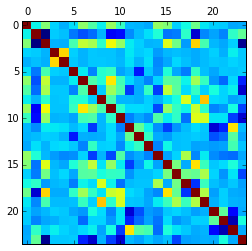

In [7]:
# Explore logical correlations

cor = data.corr(method='pearson')
plt.matshow(cor)
cor

## Part II: Supervised Learning

Countless vendors have created activity-tracking devices using similar data. For pusposes of testing, we look at wrist-only data to assess our ability to accurately predict user activity.

In [8]:
# Separate out the activity "Label" as the target attribute to predict and put
# the remaining values in X.

X = data.drop("Label")
y = data["Label"]

print X.shape
print y.shape

(14550, 24)
(14550,)


### Dimensionality reduction

Apply PCA for a different number of components to identify optimal number of components

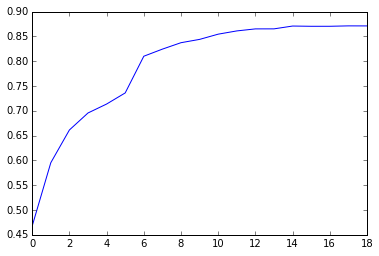

In [9]:
from sklearn.decomposition import PCA

pcaRes = []

for n in range(1,20):
    pca = PCA(n_components = n)
    X_pca = pd.DataFrame(pca.fit_transform(X))

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1234)
    
    classifier = neighbors.KNeighborsClassifier(7)
    clf = classifier.fit(X_train, y_train)

    pcaRes.append(metrics.f1_score(y_train, clf.predict(X_train)))
    

plt.plot(pcaRes)

In [10]:
# Run PCA on optimal N identified above
pca = PCA(n_components = 12)
X_pca = pd.DataFrame(pca.fit_transform(X))

print X_pca.shape
print y.shape

(14550, 12)
(14550,)


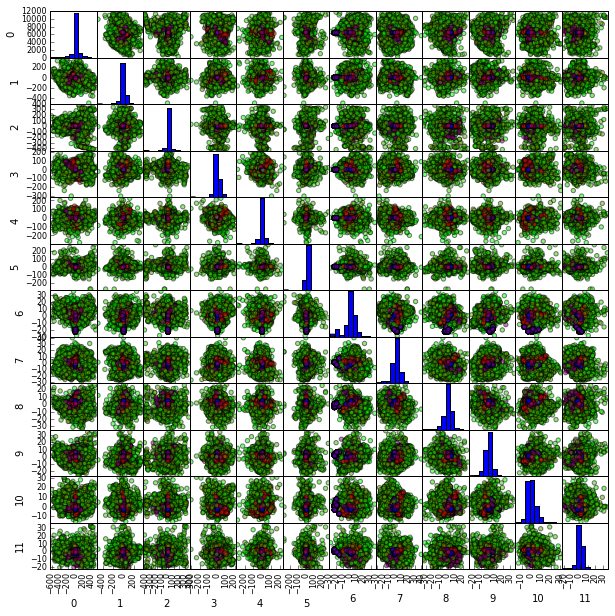

In [11]:
# Plot scatter matrix of PCA-identified features
pd.scatter_matrix(X_pca, c=y, cmap='brg', s=75, figsize=(10, 10));

### Classification

The goal is to create a classifier that can predict the "Label" feature - testing our ability to predict what activity the subject is performing given the other features.

According to the SciKit-Learn Cheat-Sheet, the recommended classifier with >100k samples is the SGD Classifier, so we explore that first (also because Linear SVC breaks).


#### K-Nearest Neighbors Optimization

We know we want to explore the results using KNN, but experimentation is required to find the optimal *k*.

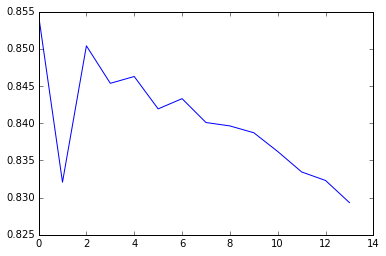

In [12]:
# Test k ranging 1-15
scores = []
for k in range(1, 15):
    clf = neighbors.KNeighborsClassifier(k)  #, weights='distance'

    clf.fit(X_train, y_train);

    scores.append(clf.score(X_test, y_test))
    
#print scores
plt.plot(scores)

The chart above indicates that *k*=1 is optimal, but doing so yields strange results below, so the second-best *k*=3 is used in further analyses.

#### Compare Classifiers

Explore results using a range of classifiers:

- KNN (n=3, as determined above)
- Decision tree
- Naïve Bayes
- Logistic Regression
- SGDClassifier (as linear SVM breaks)

In [16]:
# Set optimal KNN n as determined above
knnN = 3

# Build train/set sets restricted to PCA-selected features
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1234)

#Debugging output?
verbose = False

N = len(X_pca)
folds = 10

# Set up cross-validation folds
kf = KFold(N, n_folds=folds)

# Create array of classifiers to test
classifiers = [
#        naive_bayes.MultinomialNB(),  # Doesn't work due to negative values in one feature
        # SVC(kernel="linear")
        # svm.SVR,
        neighbors.KNeighborsClassifier(knnN), #, weights='distance'
        DecisionTreeClassifier(max_depth=3, random_state=1),
        naive_bayes.BernoulliNB(),
        linear_model.LogisticRegression(),
        linear_model.SGDClassifier(shuffle=True, loss='log')
    ]

res_f = pd.DataFrame()

# Loop through classifiers
for classifier in classifiers:
    # Build array for classifier results, to append to res_auc
    col_f = []
    splitCtr = 0
    # Loop through folds
    for train, test in kf: 
        
        if(verbose):
            print "train: "+str(train.shape)
            print "test: "+str(test.shape)

        splitCtr += 1

        # Create t/t split
        X_train, X_test, y_train, y_test = X_pca.iloc[train], X_pca.iloc[test], y.iloc[train], y.iloc[test]
        
        if(verbose):
            print "X_train: "+str(X_train.shape)
            print "X_test: "+str(X_test.shape)
            print "y_train: "+str(y_train.shape)
            print "y_test: "+str(y_test.shape)
        
        # Build model using passed classifier
        clf = classifier.fit(X_train, y_train)
        
        # Get t/t accuracy scores - not reported currently
        training_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_train, y_train)
        
        # Get array of prediction results
        y_train_predicted = clf.predict(X_train)
        
        # Calculate prec, rec and ROC AUC
        prec = metrics.precision_score(y_train, y_train_predicted)
        rec = metrics.recall_score(y_train, y_train_predicted)
        f = metrics.f1_score(y_train, y_train_predicted)
        #auc = metrics.roc_auc_score(y_train, y_train_predicted)
        
        # Append AUC to array of classifier results
        col_f.append(f)
        
        if(verbose):
            print "--------",classifier.__class__.__name__,"- Split",splitCtr,"---------"

            print "Actual 0/1 split (tr)",Counter(y_train)
            print "Prediction 0/1 split (tr)",Counter(y_train_predicted)
            print
            
            print "Accuracy on training data: %0.2f" % (training_accuracy)
            print "Accuracy on test data:     %0.2f" % (test_accuracy)
            print "Precision: ",prec
            print "Recall: ",rec
            print "F: ",f

            print y_train_predicted
        
    res_f[classifier.__class__.__name__] = col_f

# Render table
res_f

,KNeighborsClassifier,DecisionTreeClassifier,BernoulliNB,LogisticRegression,SGDClassifier
0,0.576923,0.174194,0.057878,0.071661,0.156522
1,0.599520,0.231707,0.054422,0.053156,0.108626
2,0.583541,0.247678,0.035714,0.048276,0.107335
3,0.613636,0.210843,0.059211,0.070064,0.112601
4,0.595533,0.173333,0.043011,0.074576,0.097130
5,0.644295,0.187879,0.046667,0.064309,0.107922
6,0.627358,0.208861,0.054795,0.053156,0.132231
7,0.592233,0.211838,0.034843,0.073090,0.126126
8,0.612903,0.132911,0.033333,0.063898,0.078078
9,0.621315,0.210843,0.065574,0.069182,0.087558


This demonstrates quite clearly KNN singnificantly outperfoms other classifiers. More specifically:

In [29]:
res = pd.DataFrame()
foldNum = 0;
for train, test in kf: 
    foldNum += 1
    fold_res = []
    
    if(verbose):
        print "train: "+str(train.shape)
        print "test: "+str(test.shape)

    splitCtr += 1

    # Create t/t split
    X_train, X_test, y_train, y_test = X_pca.iloc[train], X_pca.iloc[test], y.iloc[train], y.iloc[test]

    if(verbose):
        print "X_train: "+str(X_train.shape)
        print "X_test: "+str(X_test.shape)
        print "y_train: "+str(y_train.shape)
        print "y_test: "+str(y_test.shape)

    # Build model using passed classifier
    classifier = neighbors.KNeighborsClassifier(knnN)
    clf = classifier.fit(X_train, y_train)

    # Get t/t accuracy scores - not reported currently
    training_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_train, y_train)

    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)

    # Calculate prec, rec and ROC AUC
    acc = metrics.accuracy_score(y_train, y_train_predicted)
    prec = metrics.precision_score(y_train, y_train_predicted)
    rec = metrics.recall_score(y_train, y_train_predicted)
    f = metrics.f1_score(y_train, y_train_predicted)
    #auc = metrics.roc_auc_score(y_train, y_train_predicted)

    # Append AUC to array of classifier results
    col_f.append(f)

    fold_res.append(acc)
    fold_res.append(prec)
    fold_res.append(rec)
    fold_res.append(f)
    
    res[foldNum] = fold_res
    
res = res.transpose()
res.columns = ["Test Accuracy","Precision", "Recall", "F-Measure"]
res

,Test Accuracy,Precision,Recall,F-Measure
1,0.986560,0.888889,0.427046,0.576923
2,0.987247,0.912409,0.446429,0.599520
3,0.987247,0.900000,0.431734,0.583541
4,0.987018,0.900000,0.465517,0.613636
5,0.987553,0.902256,0.444444,0.595533
6,0.987858,0.905660,0.500000,0.644295
7,0.987934,0.923611,0.475000,0.627358
8,0.987171,0.903704,0.440433,0.592233
9,0.987171,0.917241,0.460208,0.612903
10,0.987247,0.913333,0.470790,0.621315


In [30]:
# Averages
res.mean(axis=0)

Test Accuracy    0.987300
Precision        0.906710
Recall           0.456160
F-Measure        0.606726
dtype: float64

### KNN Breakdown by Activity

A logical question is how well the model can predict different activities. The following analysis runs the KNN classifier for each activity.

In [17]:
res = pd.DataFrame()

for act in activityFeatures:
    
    # Create y for activity
    y = actY[act]
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1234)

    classifier = neighbors.KNeighborsClassifier(knnN)
    clf = classifier.fit(X_train, y_train)

    actRes = []
    
    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)
    
    # Calculate prec, rec and ROC AUC
    actRes.append(metrics.precision_score(y_train, y_train_predicted))
    actRes.append(metrics.recall_score(y_train, y_train_predicted))
    actRes.append(metrics.f1_score(y_train, y_train_predicted))
    
    res[act] = actRes

# Summarize output
res = res.transpose()
res.columns=["Precision","Recall","F-Measure"]
res = res.sort(["F-Measure"], ascending=False)
res

,Precision,Recall,F-Measure
is_lying,1.000000,1.000000,1.000000
is_sitting,0.999074,1.000000,0.999537
is_standing,0.986155,0.996771,0.991435
is_lifting_arms,0.934884,0.927336,0.931094
is_cycling,0.928571,0.908864,0.918612
is_walking,0.892593,0.919847,0.906015
is_bending,0.894094,0.881526,0.887765
is_jogging,0.888628,0.882421,0.885514
is_running,0.930195,0.809322,0.865559
is_bending_knees,0.875437,0.796610,0.834165


The broad spread of F-Measure across activities indicates some activities being easier to predict than others. Logically, lying down is a completely different position than any of the others, so the results are pathogonomic. While high precision indicates relatively accurate identification across all activities, low recall (and corresponding F-Measure) for some activities indicate high FP's so frequently mis-classifying things. This is likely because some of these activities are a bit ambiguous, like the difference between running and jogging. Or from the perspective of a single sensor, the difference between climbing and jumping is probably relatively small. 

### Review by Sensor

Anybody attempting to assess different activities must know which sensors are most critical:

In [18]:
res = pd.DataFrame()

# Loop through each activity
for act in activityFeatures:
    
    # Create y for activity
    y = actY[act]
    
    actRes = []
    
    # ARM
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_arm, y, test_size=0.3, random_state=1234)

    classifier = neighbors.KNeighborsClassifier(knnN)
    clf = classifier.fit(X_train, y_train)
    
    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)
    
    # Calculate F1
    actRes.append(metrics.f1_score(y_train, y_train_predicted))

    
    # ANKLE
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_ankle, y, test_size=0.3, random_state=1234)

    classifier = neighbors.KNeighborsClassifier(14)
    clf = classifier.fit(X_train, y_train)
    
    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)
    
    # Calculate F1
    actRes.append(metrics.f1_score(y_train, y_train_predicted))

    
    # CHEST
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_chest, y, test_size=0.3, random_state=1234)

    
    classifier = neighbors.KNeighborsClassifier(14)
    clf = classifier.fit(X_train, y_train)
    
    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)
    
    # Calculate F1
    actRes.append(metrics.f1_score(y_train, y_train_predicted))

    
    # ECG
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_ecg, y, test_size=0.3, random_state=1234)

    classifier = neighbors.KNeighborsClassifier(14)
    clf = classifier.fit(X_train, y_train)
    
    # Get array of prediction results
    y_train_predicted = clf.predict(X_train)
    
    # Calculate F1
    actRes.append(metrics.f1_score(y_train, y_train_predicted))

    res[act] = actRes

    
# Summarize output
res = res.transpose()
res.columns=["Arm","Ankle","Chest","ECG"]
res

,Arm,Ankle,Chest,ECG
is_standing,0.998384,0.935329,0.760087,0.023158
is_sitting,1.000000,0.986289,0.809524,0.046512
is_lying,1.000000,1.000000,1.000000,0.092280
is_walking,0.822276,0.683969,0.648918,0.003810
is_climbing,0.632759,0.422747,0.250608,0.028902
is_bending,0.722918,0.798729,0.644617,0.021782
is_lifting_arms,0.856456,0.859294,0.628692,0.000000
is_bending_knees,0.790222,0.581769,0.458015,0.042901
is_cycling,0.944730,0.600309,0.721854,0.000000
is_jogging,0.795967,0.514762,0.571047,0.016110


From these results, it is clear that the ECG is far less important than any of the three accelerometers for predicting subject activity. The arm accelerometer performs better than ankle or chest for most activities, perhaps indicating the push to develop activity-monitoring watches over belt-clips and such, like the original Fitbit.